In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score   
import os

files = [f for f in os.listdir() if f.startswith('BR')]
print(files)

['BR01_for_model.xlsx', 'BR02_for_model.xlsx', 'BR03_for_model.xlsx', 'BR04_for_model.xlsx', 'BR05_for_model.xlsx', 'BR06_for_model.xlsx', 'BR07_for_model.xlsx', 'BR08_for_model.xlsx', 'BR09_for_model.xlsx']


In [2]:
# Define parameters
mu_max = 0.870
Ks = 0.241
Ysx = 0.496

def read_data(file: str) -> pd.DataFrame:
    df = pd.read_excel(file)
    df = df.drop(0)
    return df

def plot_exp(df: pd.DataFrame, T_in: float) -> None:

    kwargs = {'marker': 'o', 
              's': 10,}

    plt.figure(figsize=(10, 10))
    plt.subplot(3, 1, 1)
    plt.scatter(df['Time'], df['Glucose'], color='blue', **kwargs)
    plt.title('Glucose')
    plt.xlabel('Time')
    plt.ylabel('Glucose')

    plt.subplot(3, 1, 2)
    plt.scatter(df['Time'], df['Biomass'], color='green', **kwargs)
    plt.title('Biomass')
    plt.xlabel('Time')
    plt.ylabel('Biomass')

    plt.subplot(3, 1, 3)
    plt.scatter(df['Time'], df['Protein'], color='red', **kwargs)
    plt.title(f'Protein induction at {T_in}°C')
    plt.xlabel('Time')
    plt.ylabel('Protein')
    plt.ylim(bottom=0)
    
    plt.tight_layout()
    plt.show()
    
def plot_simulation(sol, df: pd.DataFrame, batch: bool = True) -> None:
    if batch:
        df = df[df['Batch']==1]
        plt.figure(figsize=(10, 10))
        plt.subplot(3, 1, 1)
        plt.plot(sol.t, sol.y[0], label='Biomass', color='green')
        plt.scatter(df['Time'], df['Biomass'], color='green', label='Exp. Biomass')
        plt.legend()
        plt.xlabel('Time')
        plt.ylabel('Biomass')
        plt.subplot(3, 1, 2)
        plt.plot(sol.t, sol.y[1], label='Substrate', color='blue')
        plt.scatter(df['Time'], df['Glucose'], color='blue', label='Exp. Glucose')
        plt.legend()
        plt.xlabel('Time')
        plt.ylabel('Substrate')
        plt.tight_layout()
        plt.show()

def batch_reactor_ode(t, y):
    X, S = y
    mu = mu_max * S / (Ks + S)
    dXdt = mu * X 
    dSdt = - 1 / Ysx * mu * X
    return [dXdt, dSdt]

def simulate_batch_reactor(df: pd.DataFrame, eval: bool = True) -> pd.DataFrame:
    df = df[df['Batch']==1]
    t_span = (df['Time'].min(), df['Time'].max())
    y0 = (df['Biomass'].iloc[0], df['Glucose'].iloc[0])
    if eval:
        sol = solve_ivp(batch_reactor_ode, t_span, y0, t_eval=df['Time'])
    else:
        t_eval = np.linspace(t_span[0], t_span[1], 1000)
        sol = solve_ivp(batch_reactor_ode, t_span, y0, t_eval=t_eval)
    return sol  

In [73]:
file_name = './BR02_for_model.xlsx'

df = read_data(file_name)

try:
    T_in = df[df['Induction'] == 1]['Temperature'].mean().round(2)
except AttributeError:
    T_in = None

# plot_exp(df, T_in)

BR01_for_model.xlsx


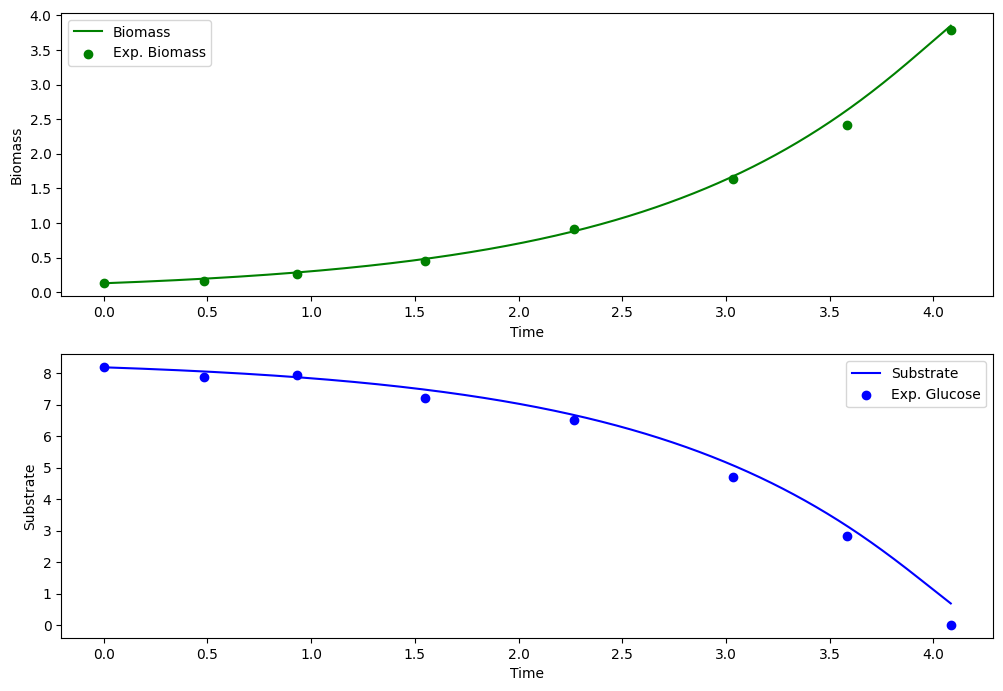

BR02_for_model.xlsx


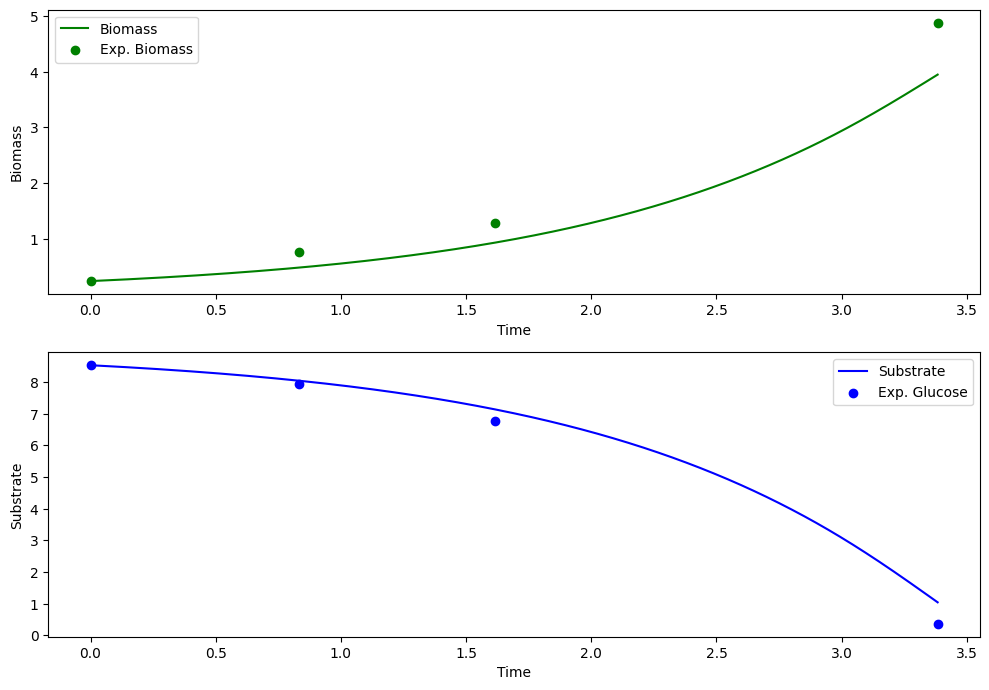

BR03_for_model.xlsx


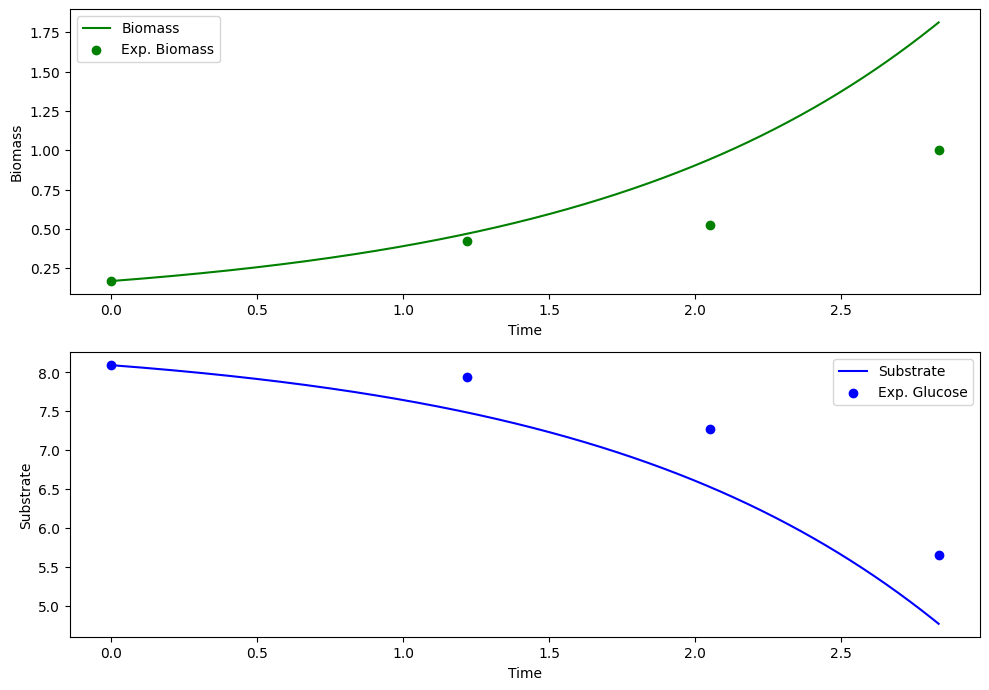

BR04_for_model.xlsx


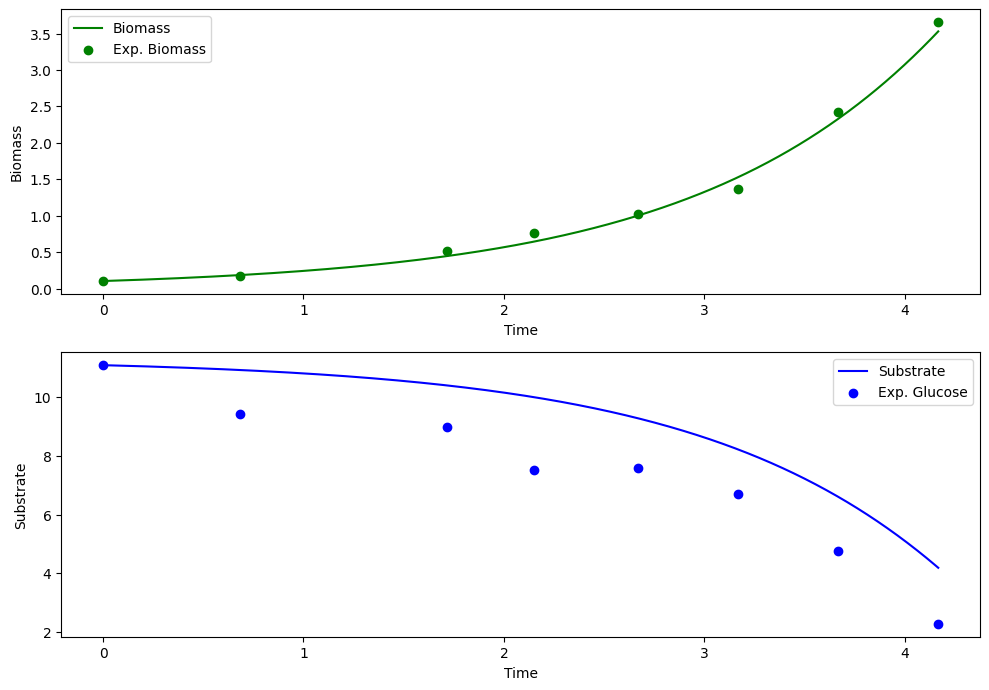

BR05_for_model.xlsx


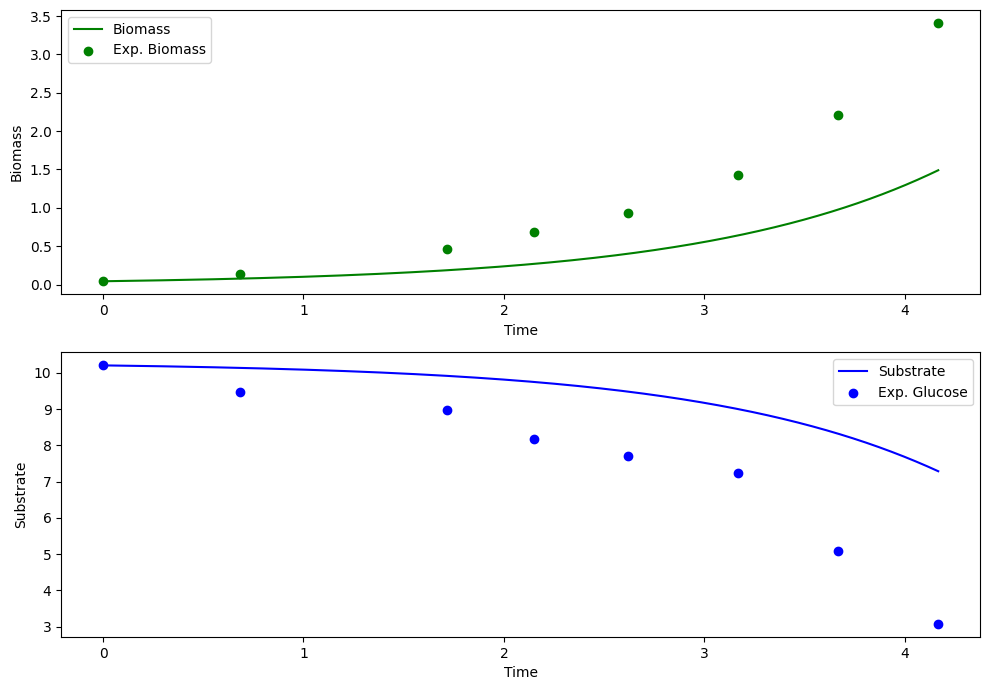

BR06_for_model.xlsx


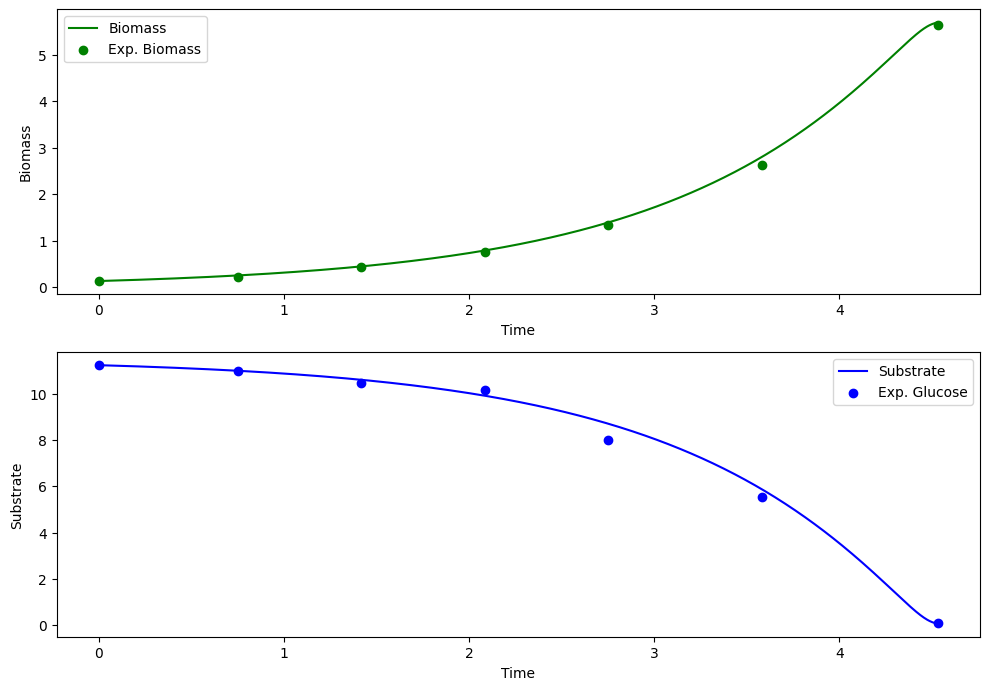

BR07_for_model.xlsx


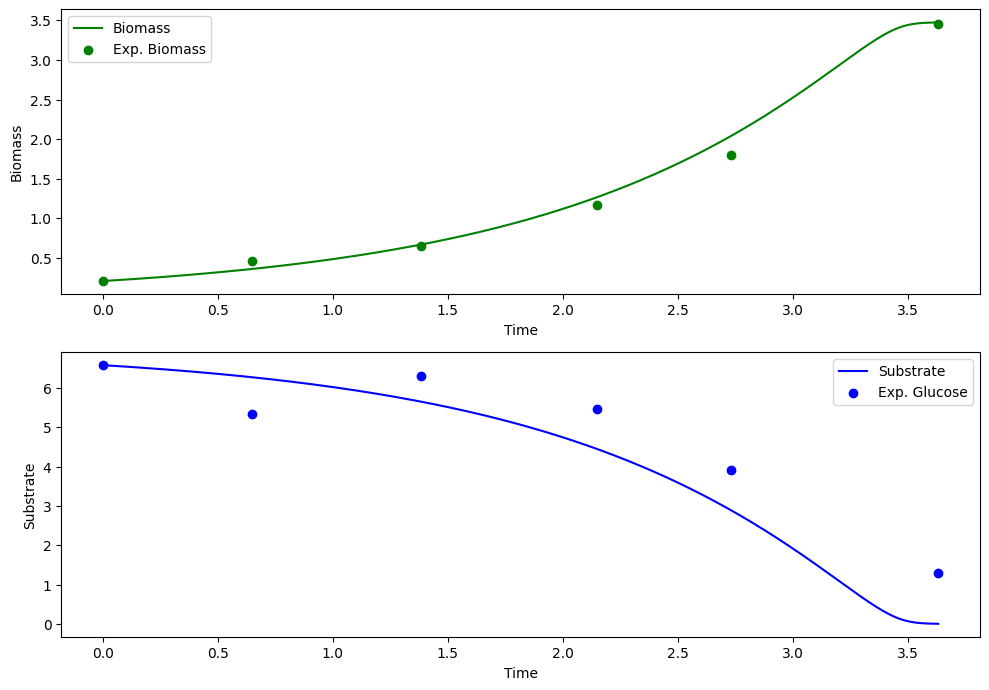

BR08_for_model.xlsx


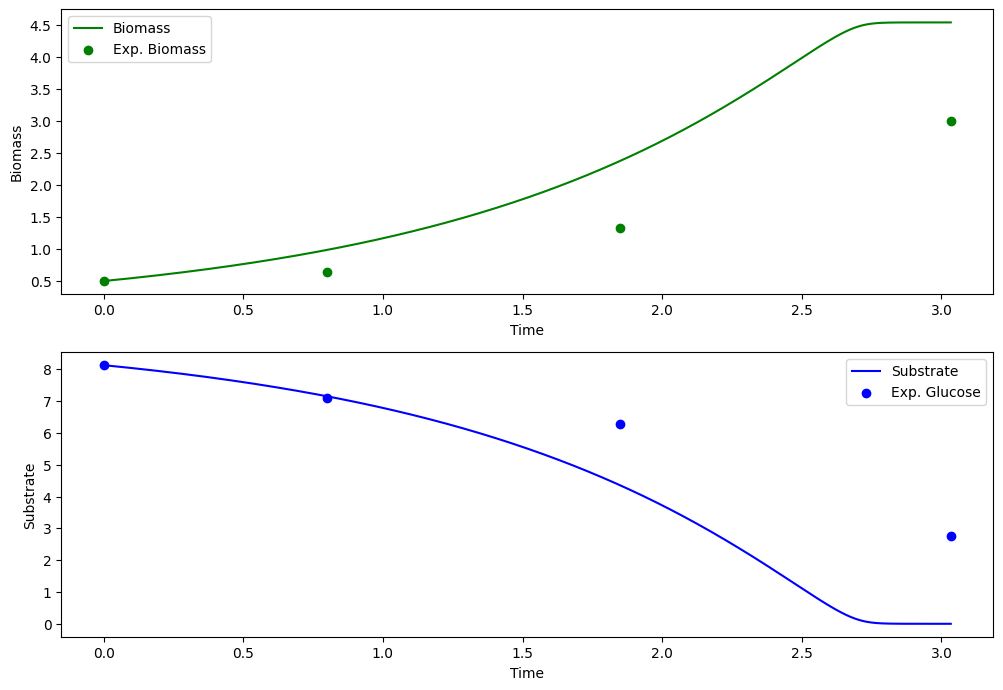

BR09_for_model.xlsx


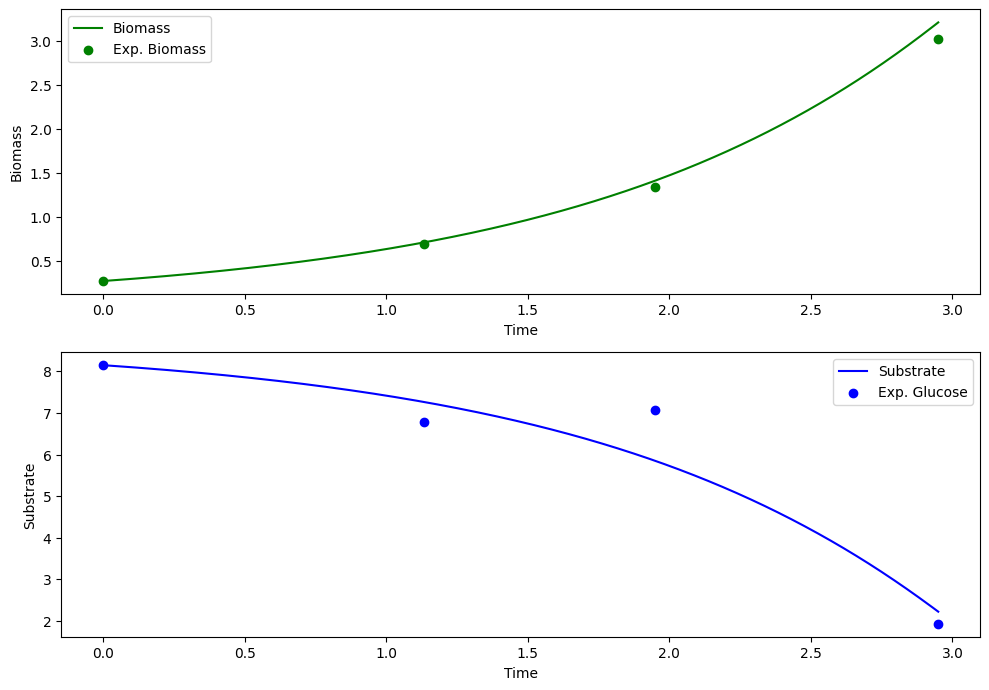

In [74]:
for file in files:
    print(file)
    df = read_data(file)
    sol = simulate_batch_reactor(df, eval=False)
    plot_simulation(sol, df)

In [109]:
MSE = []
MAE = []
R2 = []
for file in files:
    print(file)
    df = read_data(file)
    sol = simulate_batch_reactor(df, eval=True)
    
    results = pd.DataFrame(columns=['Time', 'Biomass', 'Biomass_pred', 'Glucose', 'Glucose_pred'])
    df = df[df['Batch']==1] # Keep only Batch Phase
    results['Time'] = df['Time'].values
    results['Biomass'] = df['Biomass'].values
    results['Glucose'] = df['Glucose'].values
    results['Biomass_pred'] = sol.y[0]
    results['Glucose_pred'] = sol.y[1]      
    
    # Calculate MAE, MSE, RMSE, R2
    for col in ['Biomass', 'Glucose']:
        mse = mean_squared_error(results[col], results[f'{col}_pred'])
        mae = mean_absolute_error(results[col], results[f'{col}_pred'])
        r2 = r2_score(results[col], results[f'{col}_pred'])
        
        # print(f'{col}:')
        # print(f'*** MSE: {mse:.2f}')
        # print(f'*** MAE: {mae:.2f}')
        # print(f'*** R2: {r2:.2f}')
        # print('')
        
    MSE.append(mse)
    MAE.append(mae)
    R2.append(r2)

BR01_for_model.xlsx
BR02_for_model.xlsx
BR03_for_model.xlsx
BR04_for_model.xlsx
BR05_for_model.xlsx
BR06_for_model.xlsx
BR07_for_model.xlsx
BR08_for_model.xlsx
BR09_for_model.xlsx


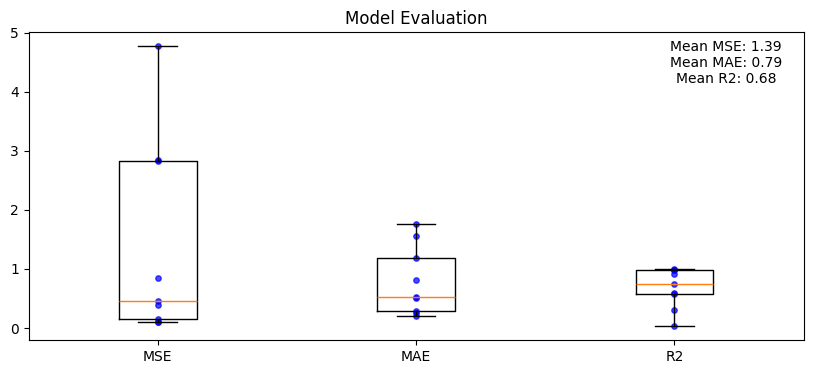

In [123]:
# Plot boxplots of MSE, MAE, R2 on the same figure
plt.figure(figsize=(10, 4))
plt.boxplot([MSE, MAE, R2], labels=['MSE', 'MAE', 'R2'])
# plot also the dots for each value
for i, value in enumerate([MSE, MAE, R2]):
    plt.scatter([i+1]*len(value), value, color='blue', s=15, alpha=0.7)
plt.title('Model Evaluation')
plt.text(0.9, 0.9, f'Mean MSE: {np.mean(MSE):.2f}\nMean MAE: {np.mean(MAE):.2f}\nMean R2: {np.mean(R2):.2f}', ha='center', va='center', transform=plt.gca().transAxes)
plt.show()